In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def detect_features(img1, img2, mask=False, detector='SIFT'):

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute Mask
    if mask:
        # Harris Corner Detector
        harris_parameters = dict(
            blockSize=2,
            ksize=3,
            k=0.04
        )

        corners1 = cv2.cornerHarris(gray1, **harris_parameters)
        corners2 = cv2.cornerHarris(gray2, **harris_parameters)

        # Perform non-maximal suppression on the corners
        threshold = 0.01 * corners1.max()
        corner_mask1 = (corners1 > threshold).astype(np.uint8)
        corner_mask2 = (corners2 > threshold).astype(np.uint8)
    else:
        corner_mask1, corner_mask2 = None, None

    # Feature Detection and Matching
    sift = cv2.SIFT_create()
    
    if detector=='SIFT':
        keypoints1, descriptors1 = sift.detectAndCompute(gray1, corner_mask1)
        keypoints2, descriptors2 = sift.detectAndCompute(gray2, corner_mask2)
        
    elif detector=='ORB':
        orb = cv2.ORB_create()
        keypoints1 = orb.detect(gray1, corner_mask1)
        keypoints2 = orb.detect(gray2, corner_mask1)

        keypoints1, descriptors1 = sift.compute(gray1, keypoints1, corner_mask1)
        keypoints2, descriptors2 = sift.compute(gray2, keypoints2, corner_mask1)
    
    else:
        print("detector not implemented!")
        exit()

    return keypoints1, keypoints2, descriptors1, descriptors2


In [3]:
def match_features(descriptors1, descriptors2, threshold=0.5):

    # Feature Matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # define the minimum count of matches
    # MIN_MATCH_COUNT = 10
    
    # Apply Lowe's ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good_matches.append(m)

    # Print count of good matches
    # print(len(good_matches))

    return good_matches

In [4]:
def recover_homography(keypoints1, keypoints2, good_matches):

    # Robust Recovery of Homography using RANSAC
    dst_left = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_right = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(dst_left, dst_right, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    return H, mask, matches_mask

In [5]:
def image_stitching(img_left, img_right, H):

    # Image Stitching
    result = cv2.warpPerspective(img_right,H,(img_left.shape[1] + img_right.shape[1], img_left.shape[0])) #wraped image
    result[0:img_left.shape[0], 0:img_left.shape[1]] = img_left
    
    return result

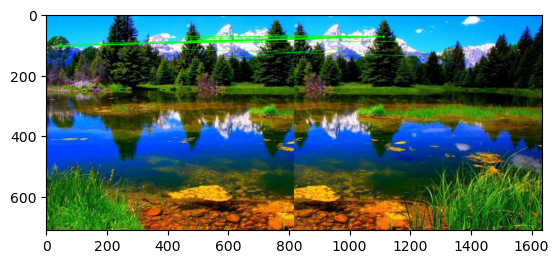

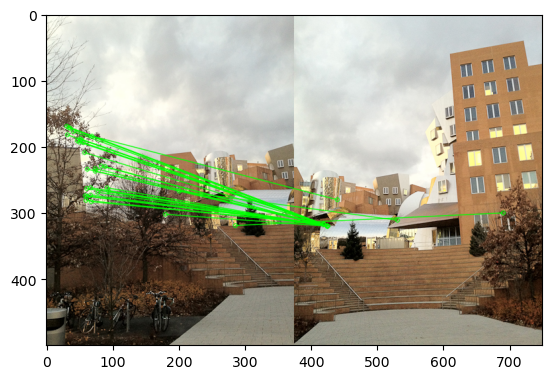

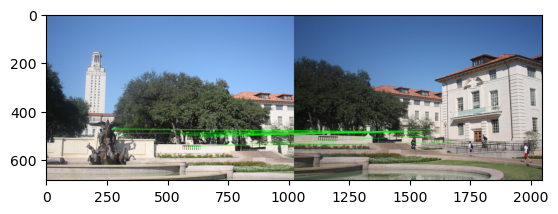

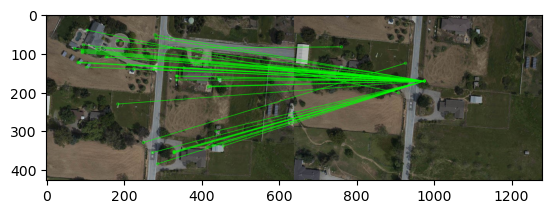

In [7]:
# load 
base_path = 'image_pairs/'
img_left_list = ['image_pairs_01_01.jpg', 'image_pairs_02_02.png', 'image_pairs_03_01.jpg', 'image_pairs_04_01.jpg']
img_right_list = ['image_pairs_01_02.jpg', 'image_pairs_02_01.png', 'image_pairs_03_02.jpg', 'image_pairs_04_02.jpg']
thresholds = [1, 1, 1, 1]

for i in range(0, len(img_left_list)):
    img_left = cv2.imread(base_path + img_left_list[i])
    img_right = cv2.imread(base_path + img_right_list[i])

    if not img_left.shape == img_right.shape:
        img_right = cv2.resize(img_right, (img_left.shape[1], img_left.shape[0]))

    keypoints1, keypoints2, descriptors1, descriptors2 = detect_features(img_left, img_right, mask=True, detector='ORB')
    good_matches = match_features(descriptors1, descriptors2, threshold=thresholds[i])
    H, mask, matches_mask = recover_homography(keypoints1, keypoints2, good_matches)

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matches_mask, # draw only inliers
                       flags = 2)
    
    mask_img = cv2.drawMatches(img_left, keypoints1, img_right, keypoints2, good_matches, None, **draw_params)
    plt.imshow(cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)),
    plt.show()

    result = image_stitching(img_left, img_right, H)

    '''plt.figure(figsize=(10, 5), dpi=300)
    plt.subplot(1, 3, 1)
    plt.title('(a) original image 01')
    plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title('(b) original image 02')
    plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 3)
    plt.title('(c) panorama image')
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))'''